# Pre-Scoping Analysis

# Load libraries

In [1]:
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import numpy as np
import requests
import geopandas
import pandas as pd
import geopandas as gpd
import rioxarray
import rasterio
import numpy as np
from shapely.geometry import mapping
from shapely.geometry import Polygon, MultiPolygon
import xarray as xr
from rioxarray.merge import merge_arrays
from rasterio.enums import Resampling
from xrspatial.classify import reclassify
import contextily as cx
import glob as glob
from rasterio import mask
import matplotlib.pyplot as plt
from shapely.geometry import box
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

# Global Settings

In [2]:
import datetime

def get_current_month_abbreviation():
    # Get current date
    current_date = datetime.datetime.now()

    # Get current month abbreviation
    month_abbreviation = current_date.strftime("%b")

    return month_abbreviation

In [3]:
usr_aoi_iso3            = 'COL'
usr_aoi_name            =  'Colombia'
usr_parent_directory    = "/home/c4ubuntu/c4gdata/N4J/"
usr_month               = get_current_month_abbreviation()
usr_year                = "2023"
client_name             = 'Nature for Justice'
usr_project_name        = 'Belgica'
custom_aoi              = 'COL_Belgica_AOI.shp'

**Build project profile**

In [4]:
project_profile = {}

project_profile['Client_Name'] = client_name
project_profile['Project_Location_Name'] = usr_project_name
project_profile['usr_aoi_iso3'] = usr_aoi_iso3

# Input & Output Directories

In [5]:
parent_directory = os.path.join(usr_parent_directory,"PreScoping_analysis")
proj_directory = os.path.join(parent_directory, usr_aoi_iso3)
os.makedirs(proj_directory, exist_ok=True)
data_directory = os.path.join(usr_parent_directory, 'Data')

# Load Parameters

In [6]:
def load_parameters(usr_parent_directory, usr_aoi_iso3, print_result=True):
    parms_csv = pd.read_csv(usr_parent_directory + "Data/CSV_Databases/Parameters_Updated.csv")
    try:
        dftmp = parms_csv.loc[parms_csv['Country']==usr_aoi_name]
        usr_aoi_iso3 = dftmp['ISO3_Code'].iloc[0]
        usr_aoi_cont = dftmp['Continent'].iloc[0]
        if print_result:
            print(usr_aoi_cont, usr_aoi_iso3)
        del parms_csv
        del dftmp
        return usr_aoi_iso3, usr_aoi_cont
    except:
        #print('Please check that you entered a valid ISO 3 country code.\nVisit https://www.iban.com/country-codes')
        del parms_csv
        return None, None

In [7]:
usr_aoi_iso3, usr_aoi_cont = load_parameters(usr_parent_directory, usr_aoi_name)

SouthAmerica COL


# Import data

In [8]:
active_projects = pd.read_csv(os.path.join(data_directory, 'CSV', f'active_{usr_aoi_cont}_projects.csv'))

In [9]:
projects_gdf = gpd.read_file(os.path.join(data_directory, 'SHP', f'{usr_aoi_cont}_projects.geojson'))

# Existing Projects Map

In [10]:
# Import country shapefile
project_aoi = gpd.read_file(os.path.join(data_directory, 'AOI', custom_aoi))

In [11]:
project_aoi.to_crs(4326, inplace=True)

In [12]:
# Find all projects in country
try:
    country_projects = active_projects.loc[active_projects['Country/Area'] == usr_aoi_name]
except Exception as e:
    print(e)

In [13]:
country_projects.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Proponent', 'Project Type',
       'AFOLU Activities', 'Methodology', 'Status', 'Country/Area',
       'Estimated Annual Emission Reductions', 'Region',
       'Project Registration Date', 'Crediting Period Start Date',
       'Crediting Period End Date'],
      dtype='object')

In [14]:
country_projects

,Unnamed: 0,ID,Name,Proponent,Project Type,AFOLU Activities,Methodology,Status,Country/Area,Estimated Annual Emission Reductions,Region,Project Registration Date,Crediting Period Start Date,Crediting Period End Date
9,1379,2532,Cumare carbon project,Reforestadora Cumare S.A.S.,Agriculture Forestry and Other Land Use,ARR,AR-ACM0003,Registered,Colombia,29180,Latin America,2022-08-08,2016-11-01,2116-10-31
10,1391,2512,AFFORESTATION OF DEGRADED GRASSLANDS IN VICHAD...,Forest First Colombia SAS,Agriculture Forestry and Other Land Use,ARR,AR-ACM0003,Registered,Colombia,139489,Latin America,2022-05-25,2016-09-15,2046-09-14
23,1581,2290,BLUE CARBON PROJECT GULF OF MORROSQUILLO “VIDA...,Conservation International Foundation,Agriculture Forestry and Other Land Use,REDD,VM0007,Registered,Colombia,31310,Latin America,2021-05-06,2015-05-15,2045-05-14
31,2530,1869,Yagual - Carbon Sequestration Grouped Project ...,Société de gestion de projets ECOTIERRA Inc.,Agriculture Forestry and Other Land Use,ARR,AR-ACM0003,Registered,Colombia,13619,Latin America,2020-06-04,2018-12-19,2048-12-18
34,2656,1769,Grouped Project for restoration of degraded la...,Multiple Proponents,Agriculture Forestry and Other Land Use,IFM; REDD,VM0005; AR-ACM0003,Registered,Colombia,6835,Latin America,2019-08-30,2015-09-01,2055-08-31
35,2662,1765,Grouped Project for reducing emissions from de...,Corporación Autónoma Regional del Río Grande d...,Agriculture Forestry and Other Land Use,REDD,VM0015,Registered,Colombia,117468,Latin America,2021-12-07,2014-03-08,2044-03-07
37,2759,1695,Scheme of Compensation for Ecosystem Services ...,Local Environmental Authority of Chivor (CORPO...,Agriculture Forestry and Other Land Use,REDD,VM0015,Registered,Colombia,1662,Latin America,2018-01-16,2014-04-11,2044-04-10
43,2863,1682,Regenerating Colombian Coffee Ecosystems,The PURE PROJECT SAS,Agriculture Forestry and Other Land Use,ARR,AR-AMS0007,Registered,Colombia,7107,Latin America,2020-04-06,2014-04-20,2054-04-19
54,3011,856,The Chocó-Darién Conservation Corridor REDD Pr...,Anthrotect S.A.S.,Agriculture Forestry and Other Land Use,REDD,VM0009,Registered,Colombia,96,Latin America,2020-04-06,2010-10-18,2040-10-17
61,3083,1395,Bajo Calima y Bahía Málaga (BCBM) REDD+ Project,Multiple Proponents,Agriculture Forestry and Other Land Use,REDD,VM0006,Registered,Colombia,498719,Latin America,2020-04-06,2013-08-26,2043-08-25


In [15]:
country_projects_table = country_projects[['Name', 'Proponent',
       'AFOLU Activities', 'Methodology','Estimated Annual Emission Reductions',
       'Project Registration Date','Crediting Period Start Date',
       'Crediting Period End Date' ]]

In [16]:
os.makedirs(os.path.join(proj_directory,f"Products/Tables/"), exist_ok=True)

In [17]:
country_projects_table

,Name,Proponent,AFOLU Activities,Methodology,Estimated Annual Emission Reductions,Project Registration Date,Crediting Period Start Date,Crediting Period End Date
9,Cumare carbon project,Reforestadora Cumare S.A.S.,ARR,AR-ACM0003,29180,2022-08-08,2016-11-01,2116-10-31
10,AFFORESTATION OF DEGRADED GRASSLANDS IN VICHAD...,Forest First Colombia SAS,ARR,AR-ACM0003,139489,2022-05-25,2016-09-15,2046-09-14
23,BLUE CARBON PROJECT GULF OF MORROSQUILLO “VIDA...,Conservation International Foundation,REDD,VM0007,31310,2021-05-06,2015-05-15,2045-05-14
31,Yagual - Carbon Sequestration Grouped Project ...,Société de gestion de projets ECOTIERRA Inc.,ARR,AR-ACM0003,13619,2020-06-04,2018-12-19,2048-12-18
34,Grouped Project for restoration of degraded la...,Multiple Proponents,IFM; REDD,VM0005; AR-ACM0003,6835,2019-08-30,2015-09-01,2055-08-31
35,Grouped Project for reducing emissions from de...,Corporación Autónoma Regional del Río Grande d...,REDD,VM0015,117468,2021-12-07,2014-03-08,2044-03-07
37,Scheme of Compensation for Ecosystem Services ...,Local Environmental Authority of Chivor (CORPO...,REDD,VM0015,1662,2018-01-16,2014-04-11,2044-04-10
43,Regenerating Colombian Coffee Ecosystems,The PURE PROJECT SAS,ARR,AR-AMS0007,7107,2020-04-06,2014-04-20,2054-04-19
54,The Chocó-Darién Conservation Corridor REDD Pr...,Anthrotect S.A.S.,REDD,VM0009,96,2020-04-06,2010-10-18,2040-10-17
61,Bajo Calima y Bahía Málaga (BCBM) REDD+ Project,Multiple Proponents,REDD,VM0006,498719,2020-04-06,2013-08-26,2043-08-25


In [18]:
country_projects_table.reset_index().to_csv(os.path.join(proj_directory,f"Products/Tables/{usr_aoi_iso3}_{usr_project_name}_projects_summary.csv"))

In [19]:
country_projects_ids = []
for i in country_projects.ID.unique().tolist():
    if str(i) in projects_gdf.ID.unique().tolist():
        country_projects_ids.append(i)

In [20]:
projects_gdf.set_index('ID', inplace=True)

In [21]:
country_projects_ids = [str(x) for x in country_projects_ids]

In [22]:
country_projects_gdf = projects_gdf.loc[country_projects_ids]

In [23]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [24]:
ocean = gpd.read_file(os.path.join(data_directory, 'SHP', 'ne_10m_ocean.shp'))

In [25]:
country_shp = world.loc[world['name']==usr_aoi_name]

In [26]:
if usr_aoi_cont == 'SouthAmerica':
    continent_shp = world.loc[world.continent == 'South America'].unary_union
else:
    continent_shp = world.loc[world.continent == usr_aoi_cont].unary_union

In [27]:
os.makedirs(os.path.join(proj_directory,f"Products/Maps/"), exist_ok=True)

/tmp/ipykernel_28762/4044630893.py:86: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_shp['centroid'] = country_shp.centroid


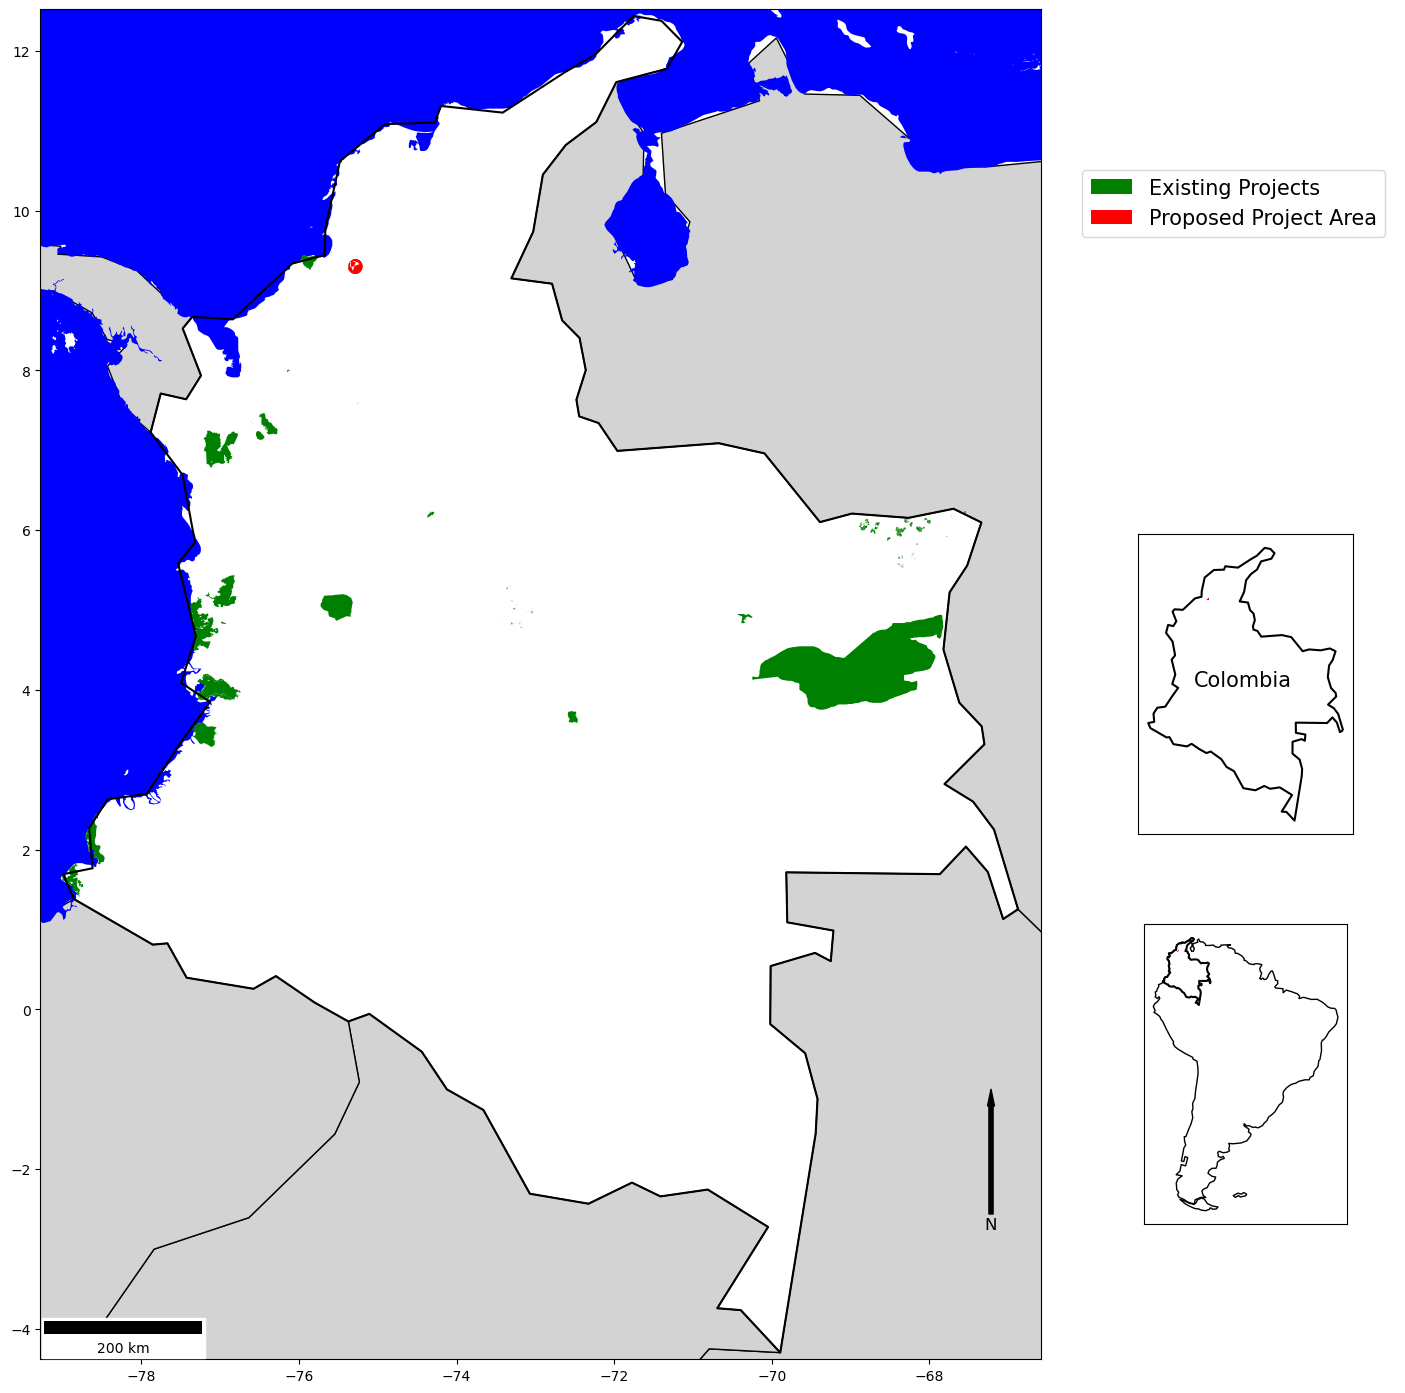

In [28]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0, figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# Calculate the xlim and ylim for the plot
xmin, ymin, xmax, ymax = country_shp.total_bounds
x_range = xmax - xmin
y_range = ymax - ymin
if x_range < y_range:
    add_dist = (y_range - x_range) / 20
    xmin -= add_dist
    xmax += add_dist
else:
    add_dist = (x_range - y_range) / 20
    ymin -= add_dist
    ymax += add_dist

# Set the plot limits
xlim = ([xmin - x_range * 0.005,  xmax + x_range * 0.005])
ylim = ([ymin - y_range * 0.005,  ymax + y_range * 0.005])
extent = box(xlim[0], ylim[0], xlim[1], ylim[1])

# Clip the world borders to the extent of the plot
world = world[world.intersects(extent)]

# Filter out the country
world = world.loc[world['name'] != usr_aoi_name]

country_shp.boundary.plot(ax=ax_map, edgecolor='black')
world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')
ocean.clip(extent).plot(ax=ax_map, facecolor='blue')

ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                 arrowprops=dict(facecolor='black', width=3, headwidth=5),
                 ha='center', va='center', fontsize=12,
                 xycoords=ax_map.transAxes)

ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

country_projects_gdf.plot(ax=ax_map, facecolor='green', label='Existing Projects')
project_aoi.boundary.plot(ax=ax_map, color='red', label='Proposed Project Area', linewidth=10)

# Manually create legend handles and labels
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, fc='green'),  # Blue rectangle for Existing Projects
    plt.Rectangle((0, 0), 1, 1, fc='red')    # Red rectangle for Proposed Project Area
]
legend_labels = ['Existing Projects', 'Proposed Project Area']

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([0.92, 0.1, 0.1, 0.8])

# Create the legend manually using the custom handles and labels
ax_legend.legend(legend_handles, legend_labels, fontsize=15)
ax_legend.axis('off')

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='black')
project_aoi.boundary.plot(ax=ax_minimap, color='red')

ax_minimap.set_xticks([])
ax_minimap.set_yticks([])


# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap_2 = fig.add_subplot(gs[1, -1])
ax_minimap_2.set_position([0.82, 0.45, 0.2, 0.2]) 
#gpd.GeoDataFrame(geometry=[continent]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap_2, edgecolor='black')
project_aoi.boundary.plot(ax=ax_minimap_2, color='red')
country_shp['centroid'] = country_shp.centroid
country_shp.apply(lambda x: ax_minimap_2.annotate(text=x['name'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), ha='center', fontsize=15), axis=1)
ax_minimap_2.set_xticks([])
ax_minimap_2.set_yticks([])


# Save the figure
filename = f"{usr_aoi_iso3}_{usr_project_name}_ProjectArea_CurrentProjects_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Project Area Map

/tmp/ipykernel_28762/3160115845.py:85: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_shp['centroid'] = country_shp.centroid


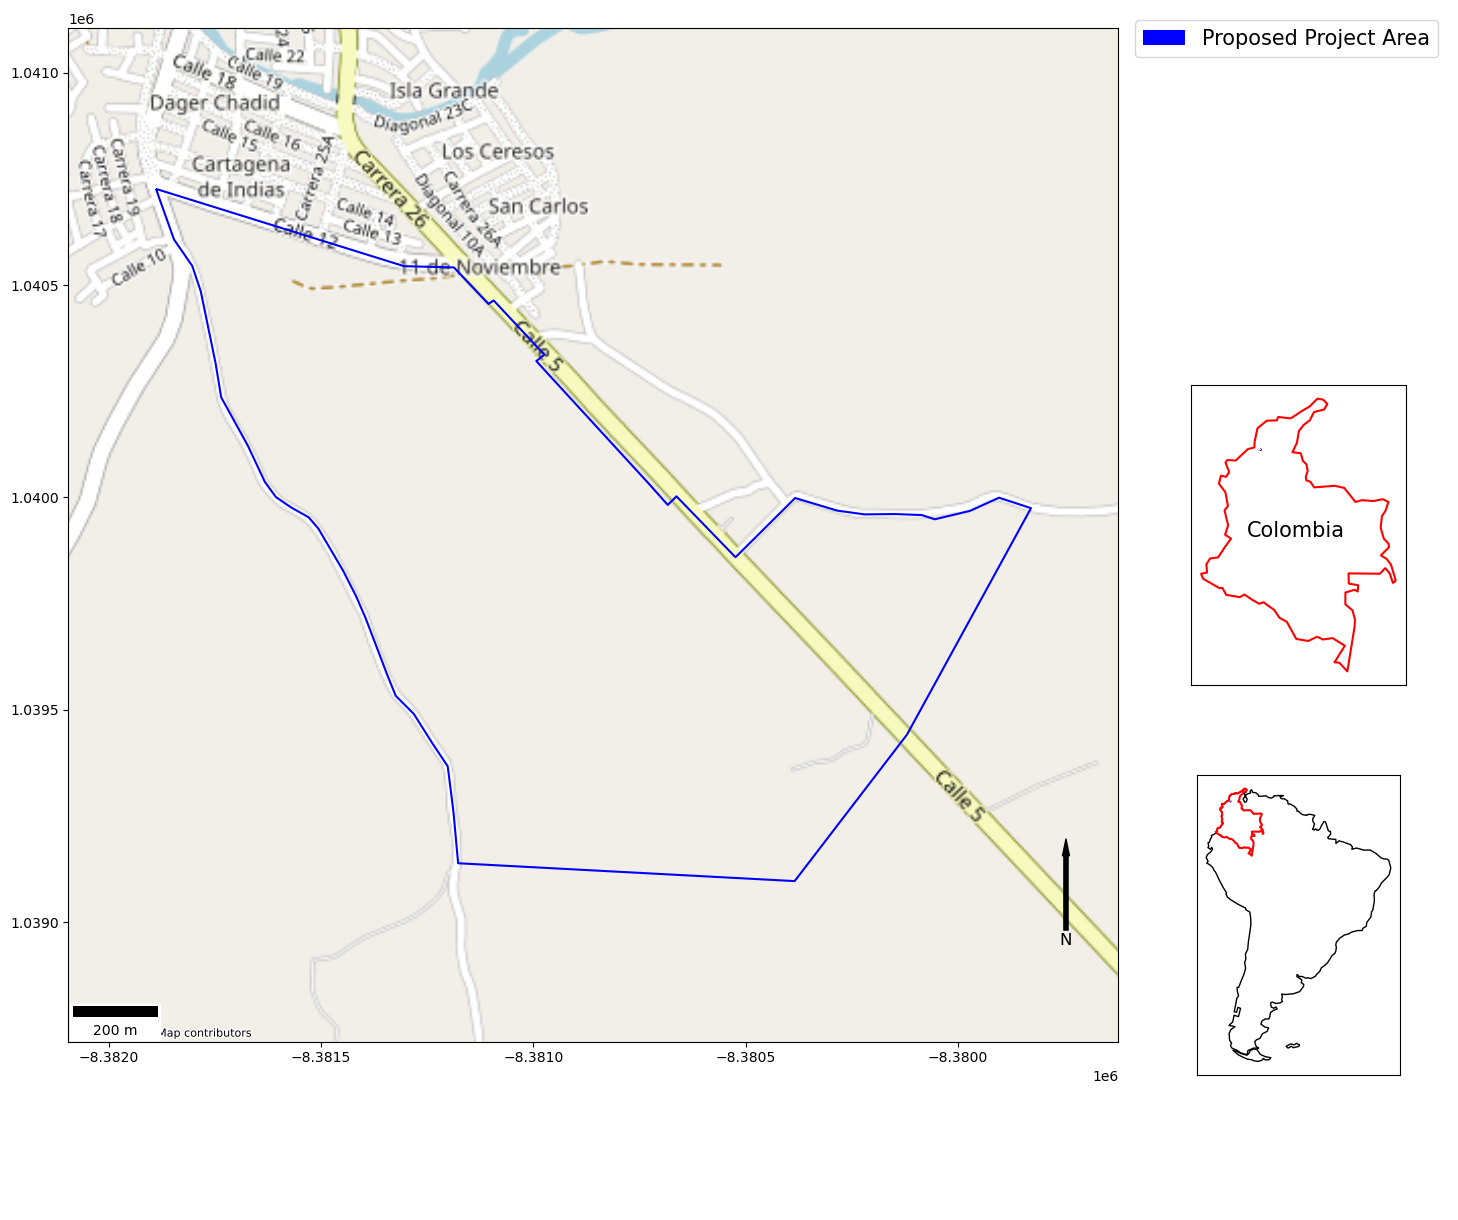

In [29]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0, figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# Calculate the xlim and ylim for the plot
xmin, ymin, xmax, ymax = project_aoi.to_crs('EPSG:3857').total_bounds
x_range = xmax - xmin
y_range = ymax - ymin
if x_range < y_range:
    add_dist = (y_range - x_range) / 2
    xmin -= add_dist
    xmax += add_dist
else:
    add_dist = (x_range - y_range) / 2
    ymin -= add_dist
    ymax += add_dist

# Set the plot limits
xlim = ([xmin - x_range * 0.1,  xmax + x_range * 0.1])
ylim = ([ymin - y_range * 0.1,  ymax + y_range * 0.1])
extent = box(xlim[0], ylim[0], xlim[1], ylim[1])

# Clip the world borders to the extent of the plot
world = world[world.intersects(extent)]

# Filter out the country_shp
world = world.loc[world['name'] != usr_aoi_name]

#country_shp.boundary.plot(ax=ax_map, edgecolor='black')
#world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')

ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(1, 'm', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                 arrowprops=dict(facecolor='black', width=3, headwidth=5),
                 ha='center', va='center', fontsize=12,
                 xycoords=ax_map.transAxes)

ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

#country_shp_projects_gdf.plot(ax=ax_map, facecolor='blue', label='Existing Projects')
project_aoi.to_crs('EPSG:3857').boundary.plot(ax=ax_map, color='blue', label='Proposed Project Area')
cx.add_basemap(ax_map, zoom=15, source=cx.providers.OpenStreetMap.Mapnik)

# Manually create legend handles and labels
legend_handles = [ 
    plt.Rectangle((0, 0), 1, 1, fc='blue')    # Red rectangle for Proposed Project Area
]
legend_labels = ['Proposed Project Area']

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([0.92, 0.1, 0.1, 0.8])

# Create the legend manually using the custom handles and labels
ax_legend.legend(legend_handles, legend_labels,  fontsize=15)
ax_legend.axis('off')
#ax_legend.get_title(fontsize=12)

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')
project_aoi.boundary.plot(ax=ax_minimap, color='blue')

ax_minimap.set_xticks([])
ax_minimap.set_yticks([])

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap_2 = fig.add_subplot(gs[1, -1])
ax_minimap_2.set_position([0.82, 0.45, 0.2, 0.2]) 
#gpd.GeoDataFrame(geometry=[continent]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap_2, edgecolor='red')
project_aoi.boundary.plot(ax=ax_minimap_2, color='blue')
country_shp['centroid'] = country_shp.centroid
country_shp.apply(lambda x: ax_minimap_2.annotate(text=x['name'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), ha='center', fontsize=15), axis=1)
ax_minimap_2.set_xticks([])
ax_minimap_2.set_yticks([])

# Save the figure
filename = f"{usr_aoi_iso3}_{usr_project_name}_ProjectArea_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Check projects in new project boundary

In [30]:
project_check = gpd.sjoin(project_aoi, country_projects_gdf, how='right', predicate='intersects')

In [31]:
projects_in_aoi = project_check.loc[project_check.index_left.notna()]

In [32]:
aoi_projects_ids = [int(x) for x in projects_in_aoi.reset_index().ID.unique().tolist()]

In [33]:
country_projects.reset_index(inplace=True)

In [34]:
aoi_projects = country_projects.loc[country_projects.ID.isin(aoi_projects_ids)]

In [35]:
if len(projects_in_aoi) > 0:
    project_profile['Existing Projects Status'] = 'Yes'
    project_profile['Existing Project Names'] = aoi_projects.Name.unique().tolist()
else:
    project_profile['Existing Projects Status'] = 'No'

In [36]:
project_profile

{'Client_Name': 'Nature for Justice',
 'Project_Location_Name': 'Belgica',
 'usr_aoi_iso3': 'COL',
 'Existing Projects Status': 'No'}

# Land-Use Map

In [37]:
landcover = rioxarray.open_rasterio(os.path.join(data_directory, 'Raster',
                                                 'PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif'))

landcover = landcover.rio.clip(project_aoi.geometry, from_disk=True)

landcover.rio.to_raster(f'{usr_aoi_iso3}_{usr_project_name}_clipped_landcover.tif')

import rasterio 

# Write raster to disk
landcover.rio.to_raster(os.path.join(proj_directory, f'{usr_aoi_iso3}_{usr_project_name}_clipped_landcover.tif'))

output_path = os.path.join(proj_directory, f'{usr_aoi_iso3}_{usr_project_name}_clipped_landcover.tif')

# Open the input raster file
with rasterio.open(output_path) as src:

    # Read the raster data as a numpy array
    data = src.read(1)

    # Set the no data value
    nodata = -9999

    # Create a new numpy array to store the reclassified data
    reclassified_data = np.zeros_like(data, dtype=np.uint8)

    # Define the reclassification thresholds and values
    thresholds = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100, 111, 112, 113, 114, 115, 116, 121, 122, 123, 124, 125, 126, 200]
    values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

    # Reclassify the data based on the thresholds and values
    for i in range(len(thresholds)-1):
        mask = np.logical_and(data > thresholds[i], data <= thresholds[i+1])
        reclassified_data[mask] = values[i+1]

    # Set the no data values
    reclassified_data[data == nodata] = 0

    # Set the color map
    cmap = {
        0: (0, 0, 0, 0),
        1: (255, 187, 34),
        2: (255, 255, 76),
        3: (240, 150, 255),
        4: (250, 0, 0),
        5: (180, 180, 180),
        6: (152, 245, 255),
        7: (0, 50, 200),
        8: (0, 150, 160),
        9: (250, 230, 160),
        10: (88, 72, 31),
        11: (0, 153, 0),
        12: (112, 102, 62),
        13: (0, 204, 0),
        14: (78, 117, 31),
        15: (0, 120, 0),
        16: (102, 96, 0),
        17: (141, 180, 0),
        18: (141, 116, 0),
        19: (160, 220, 0),
        20: (146, 153, 0),
        21: (100, 140, 0),
        22: (0, 0, 128)
    }
 

    # Set the output raster metadata
    kwargs = src.meta
    kwargs.update(
        dtype=rasterio.uint8,
        nodata=0,
        count=1,
        compress='lzw')

    # Write the reclassified data to a new raster file
    with rasterio.open(f"{usr_aoi_iso3}_{usr_project_name}_reclassified_landcover.tif", 'w', **kwargs) as dst:
        dst.write(reclassified_data, 1)

        # Set the color map for the new raster file
        dst.write_colormap(1, cmap)

In [38]:
# Open raster file
landcover = rioxarray.open_rasterio(f"{usr_aoi_iso3}_{usr_project_name}_reclassified_landcover.tif")

In [41]:
cmap_colors = [
    (0/255, 0/255,  0/255, 0/255),
    (255/255, 187/255, 34/255),
    (255/255, 255/255, 76/255),
    (240/255, 150/255, 255/255),
    (250/255, 0/255, 0/255),
    (180/255, 180/255, 180/255),
    (152/255, 245/255, 255/255),
    (0/255, 50/255, 200/255),
    (0/255, 150/255, 160/255),
    (250/255, 230/255, 160/255),
    (88/255, 72/255, 31/255),
    (0/255, 153/255, 0/255),
    (112/255, 102/255, 62/255),
    (0/255, 204/255, 0/255),
    (78/255, 117/255, 31/255),
    (0/255, 120/255, 0/255),
    (102/255, 96/255, 0/255),
    (141/255, 180/255, 0/255),
    (141/255, 116/255, 0/255),
    (160/255, 220/255, 0/255),
    (146/255, 153/255, 0/255),
    (100/255, 140/255, 0/255),
    (0/255, 0/255, 128/255)]

landcover_classes = {0:'No Data',
                    1:'Shrubs',
                    2:'Herbaceous vegetation',
                    3:'Cropland',
                    4:'Urban / built up',
                    5:'Bare / sparse vegetation',
                    6:'Snow and Ice',
                    7:'Permanent water bodies',
                    8:'Herbaceous wetland',
                    9:'Moss and lichen',
                    10:'Closed forest, evergreen needle leaf',
                    11:'Closed forest, evergreen, broad leaf',
                    12:'Closed forest, deciduous needle leaf',
                    13:'Closed forest, deciduous broad leaf',
                    14:'Closed forest, mixed',
                    15:'Closed forest, unknown',
                    16:'Open forest, evergreen needle leaf',
                    17:'Open forest, evergreen broad leaf',
                    18:'Open forest, deciduous needle leaf',
                    19:'Open forest, deciduous broad leaf',
                    20:'Open forest, mixed',
                    21:'Open forest, unknown',
                    22:'Open sea'}

# Calculate the area for each landcover class
x_resolution = 10  # Example pixel resolution in the x direction
y_resolution = 10  # Example pixel resolution in the y direction

pixel_area = x_resolution * y_resolution  # Calculate the area of a single pixel

# Get unique landcover classes
unique_classes = np.unique(landcover.squeeze())

land_cover = {}

land_cover_names = []

for i in unique_classes:
    # Create a mask where the land cover values are 2
    mask = np.where(landcover.squeeze() == i, 1, 0)
    pixel_count = np.count_nonzero(mask)
    class_name = landcover_classes.get(i)
    class_area = (pixel_count * 10000) // 10000
    land_cover[class_name] = class_area
    land_cover_names.append(class_name)
    print(class_name, class_area)

No Data 197
Herbaceous vegetation 110
Cropland 10
Urban / built up 2
Open forest, unknown 1


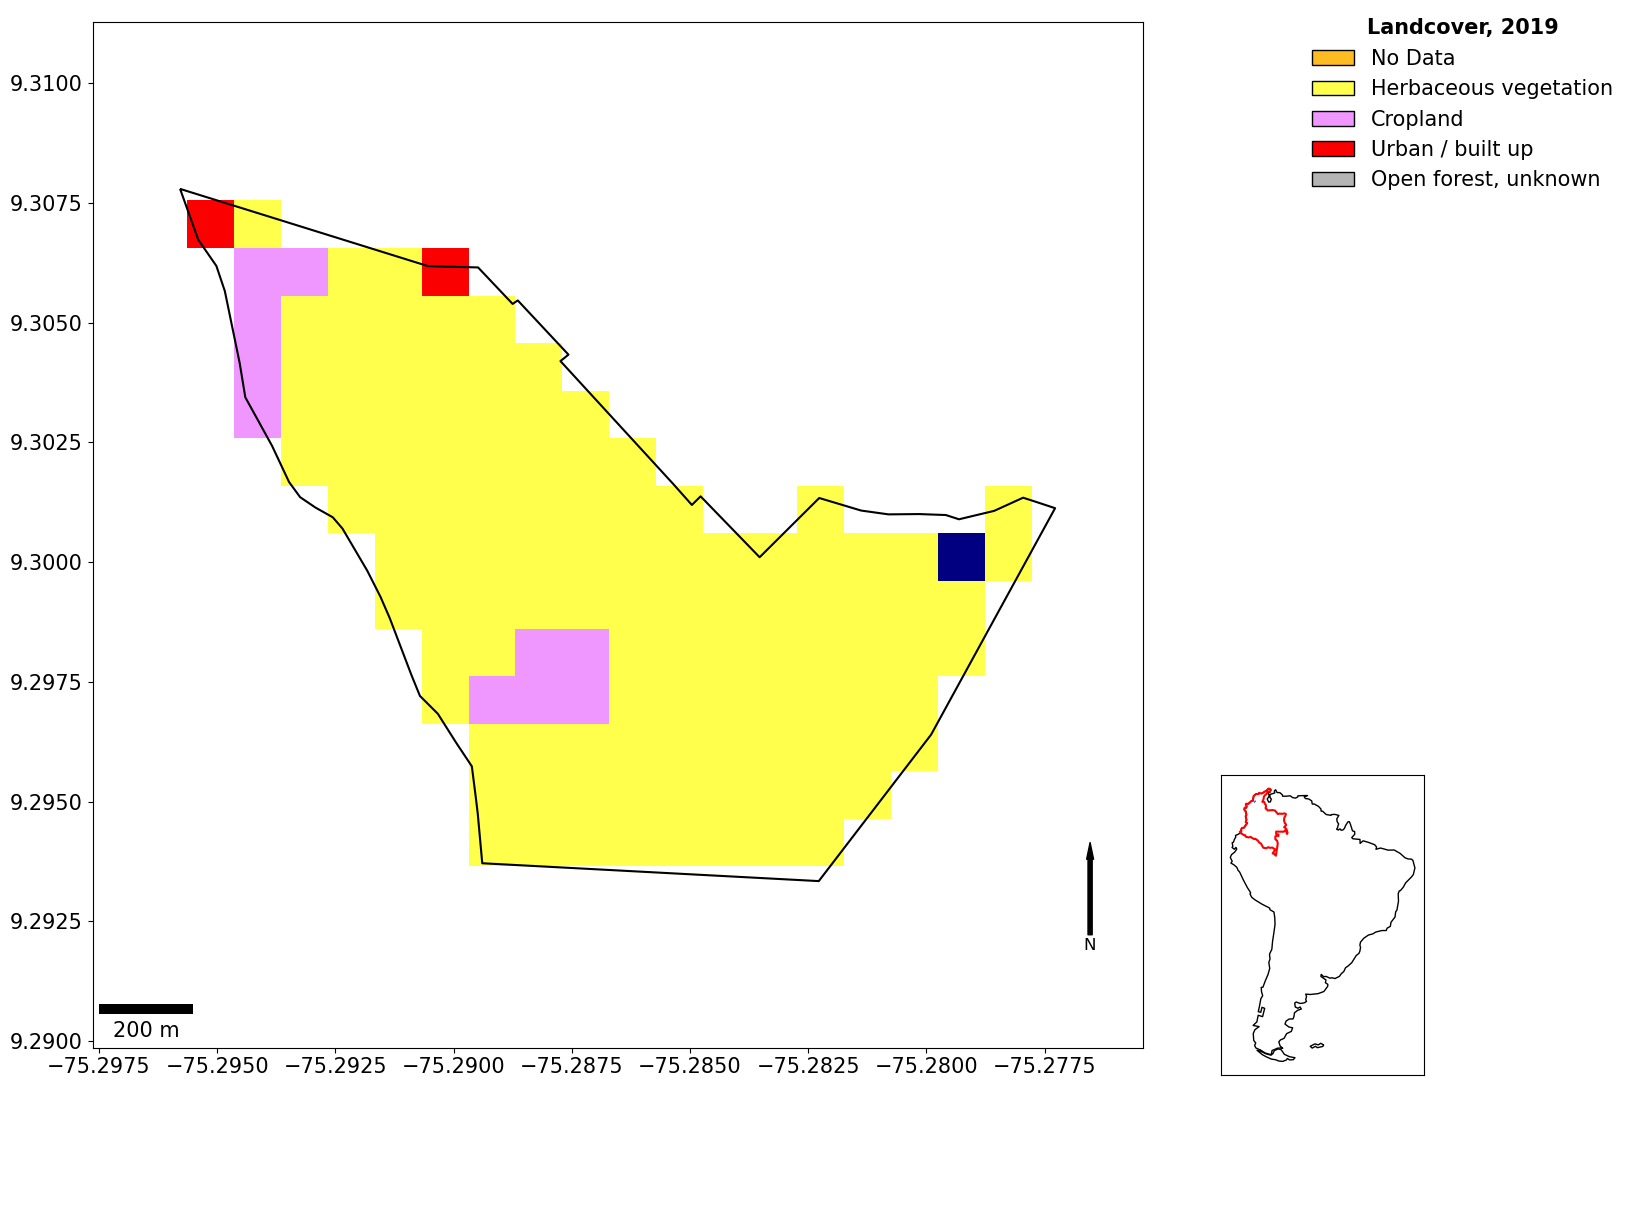

In [43]:
landcover_cmap = ListedColormap(cmap_colors)

lc_patches = [
    mpatches.Patch(facecolor=landcover_cmap(i+1), edgecolor='black', label=lc)
    for i, lc in enumerate(land_cover_names)]

plt.rcParams.update({'font.size': 15})

# Calculate the xlim and ylim for the plot
xmin, ymin, xmax, ymax = project_aoi.total_bounds
x_range = xmax - xmin
y_range = ymax - ymin
if x_range < y_range:
    add_dist = (y_range - x_range) / 2
    xmin -= add_dist
    xmax += add_dist
else:
    add_dist = (x_range - y_range) / 2
    ymin -= add_dist
    ymax += add_dist

# Set the plot limits
xlim = ([xmin - x_range * 0.1,  xmax + x_range * 0.1])
ylim = ([ymin - y_range * 0.1,  ymax + y_range * 0.1])
extent = box(xlim[0], ylim[0], xlim[1], ylim[1])

# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0,figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])


landcover.where(landcover != 255)[0].plot.imshow(ax=ax_map, add_colorbar=False, cmap=landcover_cmap)
project_aoi.boundary.plot(ax=ax_map, color='black')
#world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')
ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=5),
            ha='center', va='center', fontsize=12,
            xycoords=ax_map.transAxes)
ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([1.0, 0.1, 0.1, 0.8])
legend = ax_legend.legend(handles=lc_patches, bbox_to_anchor=(1.19, 1), borderaxespad=0., title='Landcover, 2019', frameon=False, fancybox=True)
legend.get_title().set_fontweight('bold')
legend.get_title().set_fontsize(15) 
ax_legend.axis('off')

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')
project_aoi.boundary.plot(ax=ax_minimap, color='blue')
ax_minimap.set_xticks([])
ax_minimap.set_yticks([])

filename = f"{usr_aoi_iso3}_{usr_project_name}_LandCover_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.show()

## Land Use Table

In [44]:
os.makedirs(os.path.join(proj_directory,f"Products/Tables/"), exist_ok=True)

In [45]:
land_cover_table = pd.DataFrame(land_cover, index=[0])

In [46]:
land_cover_table = land_cover_table.drop(columns='No Data')

In [47]:
land_cover_table = land_cover_table.transpose().reset_index()

In [48]:
land_cover_table = land_cover_table.rename(columns={'index':'Land Cover Class', 0:'Area (ha)'})

In [49]:
filename = f"{usr_aoi_iso3}_{usr_project_name}_LandCover_Table.csv"
land_cover_table.to_csv(os.path.join(proj_directory,f"Products/Tables/{filename}"))

### 6: Landscape Dynamics Maps

# Forest Loss map

In [50]:
def grab_hansen(shp_aoi, variable):
    # Identify IDs of corresponding hansen data from fishnet grid
    fishnet = gpd.read_file(os.path.join(data_directory, "SHP","fishnet_Named.shp"))
    ID = gpd.sjoin(shp_aoi, fishnet, how="inner")[['Name']]

    # Convert to list
    ID = ID.Name.to_list()

    # Grab corresponding Hansen data
    data_list = []

    # Loop
    for id in ID:
        id = str(id)
        print(id)
        # Check if Hansen has been downloaded
        han = os.listdir(os.path.join(data_directory, "Hansen/"))
        han = [h for h in han if f"Hansen_GFC-2021-v1.9_treecover2000_{id}.tif" in h]
        
        if len(han) == 0:
            # Download URL
            url = f"https://storage.googleapis.com/earthenginepartners-hansen/GFC-2021-v1.9/Hansen_GFC-2021-v1.9_{variable}_{id}.tif"
            file_name = os.path.basename(requests.head(url).url)
            #print(f"Downloading {file_name} from {url}")
            response = requests.get(url)
            with open(os.path.join(data_directory,"Hansen/", file_name), 'wb') as f:
                f.write(response.content)

            data = rioxarray.open_rasterio(f"{data_directory}/Hansen/Hansen_GFC-2021-v1.9_{variable}_{id}.tif", mask_and_scale=True)
            data_list.append(data)

        else:
            #print("Loading...")
            data = rioxarray.open_rasterio(f"{data_directory}/Hansen/Hansen_GFC-2021-v1.9_{variable}_{id}.tif", mask_and_scale=True)
            
            data_list.append(data)

    mosaic = merge_arrays(data_list).squeeze()
    
    data_clipped = mosaic.rio.clip(shp_aoi.geometry.apply(mapping), from_disk=True,  drop=True)
    
    return(data_clipped)

In [52]:
def load_loss(usr_aoi_iso3, aoi_national):
    if os.path.exists(f'{data_directory}/Raster/{usr_aoi_iso3}_{usr_project_name}_treeloss.tif'):
        #print('Loss exits. Loading...')
        aoi_national_treeloss = rioxarray.open_rasterio(f'{data_directory}/Raster/{usr_aoi_iso3}_{usr_project_name}_treeloss.tif', mask_and_scale=True)
    else:
        #print('Downloading and loading Loss...')     
        aoi_national_treeloss = grab_hansen(project_aoi, variable='lossyear')
        aoi_national_treeloss.rio.to_raster(f'{data_directory}/Raster/{usr_aoi_iso3}_{usr_project_name}_treeloss.tif')
    return aoi_national_treeloss

In [53]:
def load_loss_reclass(usr_aoi_iso3, aoi_national_treeloss):
    if os.path.exists(f'{data_directory}/Raster/{usr_aoi_iso3}_{usr_project_name}_treeloss_reclass.tif'):
        #print('Reclassified Loss exits. Loading...')
        aoi_national_treeloss_reclass = rioxarray.open_rasterio(f'{data_directory}/Raster/{usr_aoi_iso3}_{usr_project_name}_treeloss_reclass.tif', mask_and_scale=True)
    else:
        #print('Downloading and loading reclassified loss...')  
        aoi_national_treeloss_reclass = reclassify(aoi_national_treeloss.squeeze(), bins=[1, np.inf],new_values=[0, 1])
        aoi_national_treeloss_reclass = aoi_national_treeloss_reclass.rio.clip(project_aoi.geometry.apply(mapping), from_disk=True, drop=True)
        aoi_national_treeloss_reclass.rio.to_raster(f'{data_directory}/Raster/{usr_aoi_iso3}_{usr_project_name}_treeloss_reclass.tif')
        #dbutils.fs.mv(f'file:/databricks/driver/{usr_aoi_iso3}_treeloss_reclass.tif', f'/mnt/fnrb/fNRB_analysis/{usr_aoi_iso3}/{usr_aoi_iso3}_treeloss_reclass.tif')
    return aoi_national_treeloss_reclass

In [54]:
project_aoi.drop(columns={'Name'}, inplace=True)

In [55]:
aoi_national_treeloss = load_loss(usr_aoi_iso3, project_aoi)

10N_080W


In [56]:
aoi_national_treeloss_reclass = load_loss_reclass(usr_aoi_iso3, aoi_national_treeloss)

/tmp/ipykernel_28762/2378715916.py:53: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_shp['centroid'] = country_shp.centroid


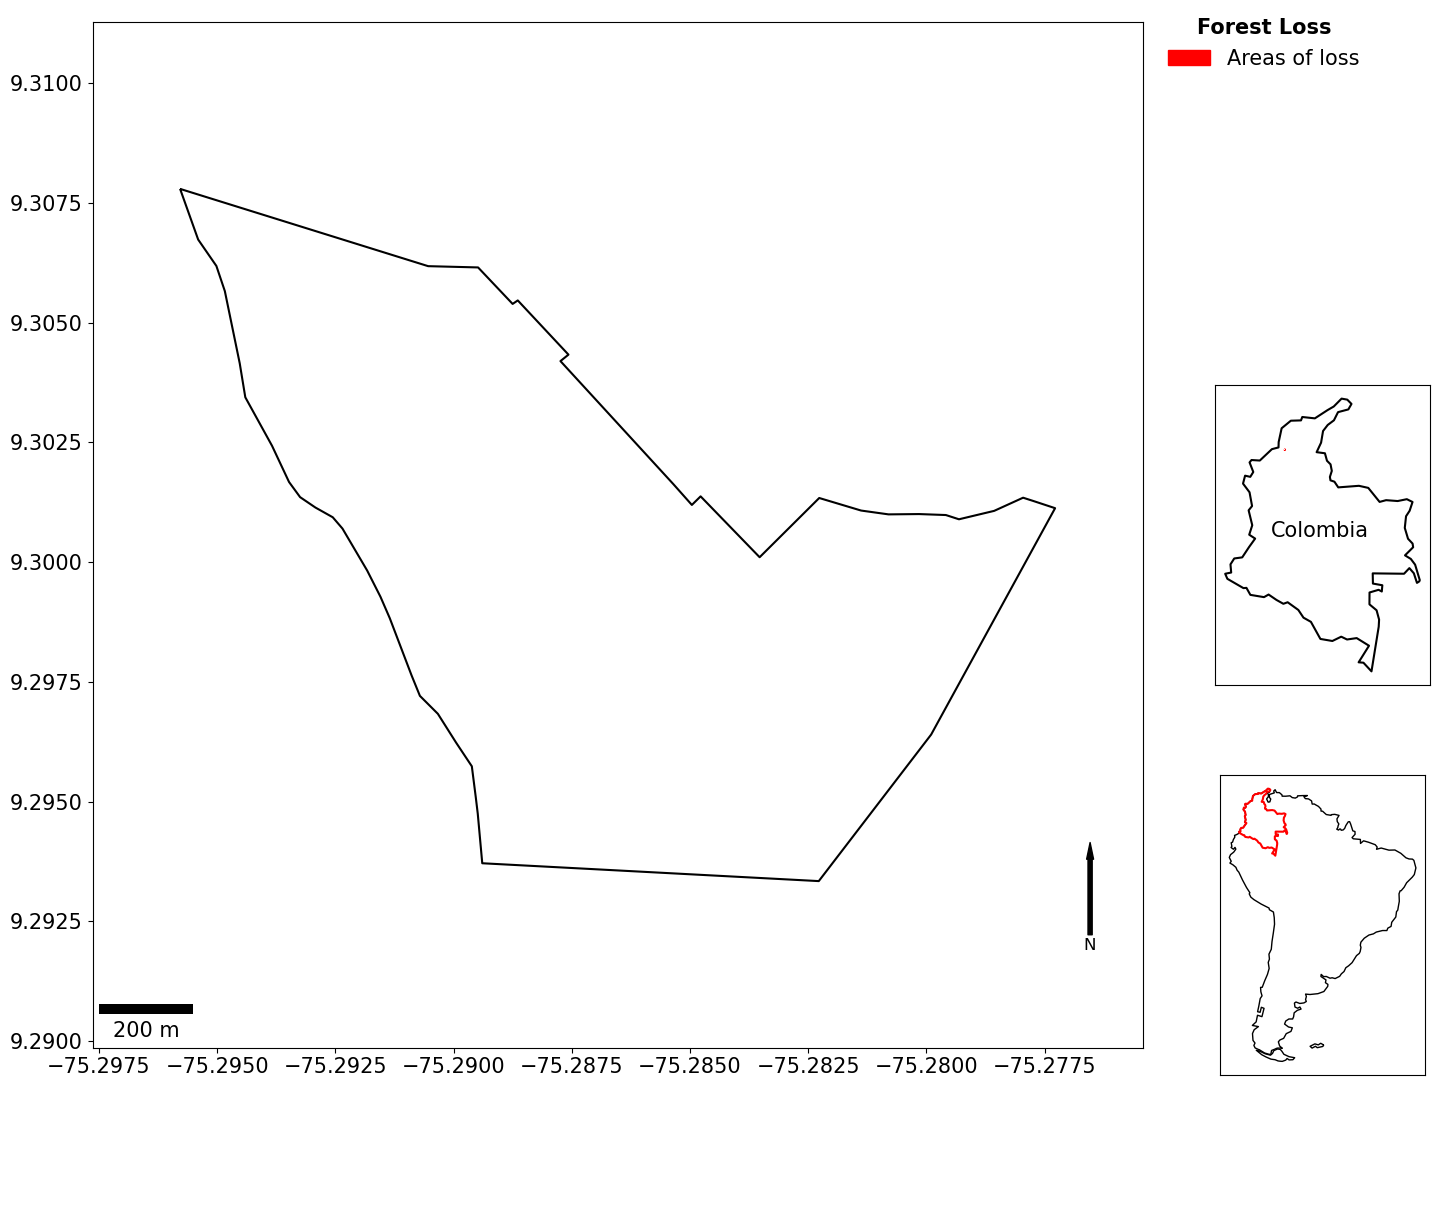

In [58]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0,figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# Load and plot the tree cover raster
src = rioxarray.open_rasterio(f'{data_directory}/Raster/{usr_aoi_iso3}_{usr_project_name}_treeloss_reclass.tif')
src.where(src ==1)[0].plot.imshow(ax=ax_map, cmap='Reds_r', add_colorbar=False)

project_aoi.boundary.plot(ax=ax_map, color='black')
#world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')
ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=5),
            ha='center', va='center', fontsize=12,
            xycoords=ax_map.transAxes)
ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([0.85, 0.1, 0.1, 0.8])
# Add the legend
legend_patch = mpatches.Patch(color='red', label='Areas of loss')
legend = ax_legend.legend(handles=[legend_patch],borderaxespad=0.,title='Forest Loss',frameon=False, fancybox=True, fontsize=15)
legend.get_title().set_fontsize(15)  # Increase the size of the legend title
legend.get_title().set_fontweight('bold')
ax_legend.axis('off')

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')
ax_minimap.set_xticks([])
ax_minimap.set_yticks([])


# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap_2 = fig.add_subplot(gs[1, -1])
ax_minimap_2.set_position([0.82, 0.45, 0.2, 0.2]) 
#gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap_2, edgecolor='black')
project_aoi.boundary.plot(ax=ax_minimap_2, color='red')
country_shp['centroid'] = country_shp.centroid
country_shp.apply(lambda x: ax_minimap_2.annotate(text=x['name'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), ha='center', fontsize=15), axis=1)
ax_minimap_2.set_xticks([])
ax_minimap_2.set_yticks([])


# Save the figure
filename = f"{usr_aoi_iso3}_{usr_project_name}_WoodyLoss_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.show()

# Disaggregate GEZ

In [59]:
def process_gez(usr_parent_directory, aoi_national):
    crs_proj = aoi_national.estimate_utm_crs()

    # Crop and load global GEZ
    #print("Projecting GEZ...")
    aoi_fao_gez = gpd.read_file(os.path.join(usr_parent_directory, "Data/gez2010/gez_2010_wgs84.shp"))
    aoi_fao_gez = aoi_fao_gez.clip(aoi_national)
    aoi_fao_gez = aoi_fao_gez.to_crs(crs=crs_proj)
    aoi_fao_gez['gez_name'] = aoi_fao_gez['gez_name'].astype(str)

    # Check if water is present
    water_check = aoi_fao_gez["gez_name"].astype(str).tolist()
    if "Water" in water_check:
        aoi_fao_gez["area"] = aoi_fao_gez.geometry.area
        # ID largers other GEZ
        if aoi_fao_gez.shape[0] > 1:
            rename = aoi_fao_gez[aoi_fao_gez["gez_name"] != "Water"].nlargest(1, "area")["gez_name"].astype(str).tolist()[0]
        # Reclassify water
        aoi_fao_gez["gez_name"] = np.where(aoi_fao_gez["gez_name"] == "Water", rename, aoi_fao_gez["gez_name"])
        aoi_fao_gez = gpd.GeoDataFrame(aoi_fao_gez, geometry="geometry")
        del rename
    del water_check

    # Write the file to disk
    aoi_aoi_iso3 = os.path.basename(usr_parent_directory)
    aoi_fao_gez.to_file(f"{usr_parent_directory}/{aoi_aoi_iso3}_fao_gez.geojson", driver="GeoJSON", quiet=True)
    
    return aoi_fao_gez

In [60]:
def disaggregate_gez(raster, poly_gez, threshold=0, crs_proj=None):
    """
    Disaggregate woody cover data of a given raster by the Global Ecological Zones (GEZ) for the same extent.
    :param rast: A raster of the woody cover in the area of interest.
    :param poly_gez: A GeoDataFrame of the GEZ. This should be projected to the relevant CRS of the raster.
    :param scaling: A scaling factor by which the raster data will be scaled. If the raster has the woody cover as a
                    percentage (0-100), then scaling = 1 (default). If the raster has decimals (0-1), then scaling = 100.
    :param crs_proj: The CRS to reproject the raster to. If None, the function will attempt to use the CRS of the
                     GeoDataFrame.
    :return: A DataFrame of the total woody area per GEZ.
    """
    # Set the CRS
    if raster.rio.crs is None:
        raster = raster.rio.write_crs(4326)

    # Reproject the raster if a new CRS is specified
    if crs_proj is not None:
        raster = raster.rio.reproject(crs_proj)

    #set nodata
    if raster.rio.nodata is None:
        raster.rio.write_nodata(-9999, inplace=True)

    raster = raster.where(raster!= raster.rio.nodata)

    poly_gez = poly_gez.to_crs(crs_proj)
    # Get the name of the GEZ
    aoi_zones = poly_gez['gez_name'].tolist()
    # Get the cell size of the raster
    res_x, res_y = raster.rio.resolution()
    
    aoi_cell_size = abs(res_x * res_y)
    aoi_zone_code = poly_gez['gez_abbrev'].tolist()
    
    # Initialize the output dataframe
    aoi_output = {'gez_name': aoi_zones,
                  'Cover_ha': [],
                  'Area_ha': [],
                  'Total_ha': []}
    # Calculate cover per GEZ
    for i in range(len(aoi_zones)):
        print("Disaggregating GEZ: {}. {} zones remaining.".format(aoi_zone_code[i], len(aoi_zone_code) - i - 1))
        aoi_zone_single = poly_gez[poly_gez['gez_abbrev'] == aoi_zone_code[i]]
        #print(len(aoi_zone_single))
        # Clip the raster to the extent of the polygon
        try:
            clipped_rast  = raster.rio.clip(aoi_zone_single.geometry.apply(mapping))
            aoi_cover_p =  clipped_rast.where(clipped_rast != clipped_rast.rio.nodata)
            aoi_cover_p = aoi_cover_p.stack(stacked=[...])
        except:
            clipped_rast = xr.DataArray()
            aoi_cover_p = clipped_rast

        # Extract the raster values within the GEZ polygon
        # Calculate the total woody area per GEZ in hectares
        
        aoi_output['Cover_ha'].append(np.count_nonzero(aoi_cover_p.values[(~np.isnan(aoi_cover_p.values))&(aoi_cover_p.values>threshold)]) * 900 / 10000)
        # Calculate the total area of the GEZ in hectares
        aoi_output['Area_ha'].append(len(aoi_cover_p.values[~np.isnan(aoi_cover_p.values)]) * aoi_cell_size / 10000)
        # Calculate the total area of the GEZ in hectares
        aoi_output['Total_ha'].append(aoi_zone_single.geometry.area.values[0] / 10000)

    return pd.DataFrame(aoi_output)

In [61]:
aoi_fao_gez = process_gez(usr_parent_directory, project_aoi)

# Treecover 2000 Map

In [62]:
def load_treecover(usr_aoi_iso3, aoi_national):
    if os.path.exists(f'{data_directory}/Raster/{usr_aoi_iso3}_{usr_project_name}_2000_treecov.tif'):
        #print('Treecover exists. Loading...')
        aoi_national_treecov = rioxarray.open_rasterio(f'{data_directory}/Raster/{usr_aoi_iso3}_{usr_project_name}_2000_treecov.tif', mask_and_scale=True)
    else:
        #print('Downloading and loading Treecover...')
        aoi_national_treecov = grab_hansen(aoi_national, variable='treecover2000')
        aoi_national_treecov.rio.to_raster(f'{data_directory}/Raster/{usr_aoi_iso3}_{usr_project_name}_2000_treecov.tif')
        #dbutils.fs.mv(f'file:/databricks/driver/{usr_aoi_iso3}_2000_treecov.tif', f'/mnt/fnrb/fNRB_analysis/{usr_aoi_iso3}/{usr_aoi_iso3}_2000_treecov.tif')
    return aoi_national_treecov

In [63]:
aoi_national_treecov = load_treecover(usr_aoi_iso3, project_aoi)

10N_080W


In [64]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0,figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])



src = rioxarray.open_rasterio(f"{data_directory}/Raster/{usr_aoi_iso3}_{usr_project_name}_2000_treecov.tif")
src[0].plot.imshow(ax=ax_map, cmap='Greens', add_colorbar=False)

project_aoi.boundary.plot(ax=ax_map, color='black')
#world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')

ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=5),
            ha='center', va='center', fontsize=12,
            xycoords=ax_map.transAxes)

ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([0.86, 0.1, 0.1, 0.8])
# Define the class names and colors
classes = [('0-30%', 'lightgreen'), ('30-60%', 'mediumseagreen'), ('60-100%', 'darkgreen')]

# Add the legend
legend_patches = []
for i, (label, color) in enumerate(classes):
    legend_patches.append(mpatches.Patch(color=color, label=label))

legend = ax_legend.legend(handles=legend_patches, borderaxespad=0.,title='Percent Treecover',frameon=False, fancybox=True, fontsize=15)
legend.get_title().set_fontweight('bold')
legend.get_title().set_fontsize(15)  # Increase the size of the legend title

ax_legend.axis('off')

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')
ax_minimap.set_xticks([])
ax_minimap.set_yticks([])

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap_2 = fig.add_subplot(gs[1, -1])
ax_minimap_2.set_position([0.82, 0.45, 0.2, 0.2]) 
#gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap_2, edgecolor='black')
project_aoi.boundary.plot(ax=ax_minimap_2, color='red')
country_shp['centroid'] = country_shp.centroid
country_shp.apply(lambda x: ax_minimap_2.annotate(text=x['name'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), ha='center', fontsize=15), axis=1)
ax_minimap_2.set_xticks([])
ax_minimap_2.set_yticks([])

# Save the figure
filename = f"{usr_aoi_iso3}_{usr_project_name}_Woody2000_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.close()

/tmp/ipykernel_28762/3741677372.py:62: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_shp['centroid'] = country_shp.centroid


# Produce Treecover and Treeloss table

### Produce CSVs

In [67]:
crs_proj = project_aoi.estimate_utm_crs()

variables = [
    (aoi_national_treecov.squeeze(), "2000 Total woody cover"),
    (aoi_national_treeloss_reclass.squeeze(), "2000-2021 Woody cover loss")
]

aoi_gez_cover = pd.concat([
    disaggregate_gez(raster=raster, poly_gez=aoi_fao_gez, threshold=30 if var_name != "2000-2021 Woody cover loss" else 0, crs_proj=crs_proj)
    .assign(Variable=var_name)
    for raster, var_name in variables
])

output_directory = os.path.join(proj_directory, "CSVs")
os.makedirs(output_directory, exist_ok=True)
output_path = os.path.join(output_directory, f"{usr_aoi_iso3}_{usr_project_name}_Tree cover disaggregated by GEZ_ha.csv")
aoi_gez_cover.to_csv(output_path, index=False)
print("Treecover compiled.")

Disaggregating GEZ: TAwa. 0 zones remaining.
Disaggregating GEZ: TAwa. 0 zones remaining.
Treecover compiled.


/home/c4ubuntu/anaconda3/envs/cnn_env/lib/python3.11/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/home/c4ubuntu/anaconda3/envs/cnn_env/lib/python3.11/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/home/c4ubuntu/anaconda3/envs/cnn_env/lib/python3.11/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/home/c4ubuntu/anaconda3/envs/cnn_env/lib/python3.11/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the dat

In [66]:
def calculate_tree_cover(tree_cover_list, output_dir, output_name):
    # Merge and sum per GEZ
    tree_cover = pd.concat([pd.read_csv(f) for f in tree_cover_list], ignore_index=True)
    tree_cover_p = tree_cover.pivot_table(index="gez_name", columns="Variable", values="Cover_ha", aggfunc=sum)

    # Select columns and calculate Remote_Unprotected
    tree_cover = tree_cover_p[['2000 Total woody cover',
           '2000-2021 Woody cover loss']]
    #tree_cover["Remote_Unprotected"] = tree_cover_p["2021 Total woody cover"] - tree_cover_p["2021 Accessible wood cover"] - tree_cover_p["2021 Protected wood cover"]
    tree_cover.index.name = 'Global Ecological Zone'
    tree_cover.reset_index(inplace=True)

    # Get total
    tree_cover_totals = tree_cover.sum(numeric_only=True)
    tree_cover_totals = pd.DataFrame(tree_cover_totals).transpose().reset_index()
    tree_cover_totals['Global Ecological Zone'] = 'Total'
    tree_cover_totals = tree_cover_totals[['Global Ecological Zone','2000 Total woody cover',
                                           '2000-2021 Woody cover loss']]
    tree_cover = pd.concat([tree_cover,tree_cover_totals], axis=0, ignore_index=True)

    # Save to csv
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, output_name)
    round(tree_cover).to_csv(output_file, index=False)
    #print('Saved Treecover Table to', output_file)
    
    return tree_cover

In [68]:
# Load tree tree cover
tree_cover_list = [os.path.join(proj_directory, 'CSVs', file) for file in os.listdir(os.path.join(proj_directory, 'CSVs')) if f'{usr_aoi_iso3}_{usr_project_name}_Tree cover disaggregated by GEZ_ha.csv' in file]
output_dir = os.path.join(proj_directory, "Products", "Tables")
output_name = f"{usr_aoi_iso3}_Accessible_Woody_Cover_Total_Forest_Cover.csv"
tree_cover = calculate_tree_cover(tree_cover_list, output_dir, output_name)
tree_cover = tree_cover.round()

# Agri 2003

In [69]:
def check_coverage(file, aoi, filename):
    # Open the raster datasets
    dataset1 = rasterio.open(file)

    # Get the extent of the datasets
    x_min1, y_min1, x_max1, y_max1 = dataset1.bounds

    # Define your area of interest (AOI)
    minx, miny, maxx, maxy = aoi.total_bounds

    # Check if the datasets overlap the AOI
    if x_max1 < minx or x_min1 > maxx or y_max1 < miny or y_min1 > maxy:
        print("Dataset 1 does not overlap the AOI.")
    else:
        print("Dataset 1 overlaps the AOI.")
        filename.append(file)
    # Close the datasets
    dataset1.close()
    return filename

In [70]:
for year in ['2003', '2019']:
    filename = []
    files = glob.glob(os.path.join(data_directory, 'Raster','Cropland', f'*{year}.tif'))    
    for file in files:
        crop_file = check_coverage(file, project_aoi, filename)
    print(crop_file[0])
    # Open the raster dataset
    dataset = rasterio.open(crop_file[0])

    # Define your area of interest (AOI) coordinates
    aoi_x_min, aoi_y_min, aoi_x_max, aoi_y_max = project_aoi.total_bounds

    # Convert AOI coordinates to dataset pixel coordinates
    window = dataset.window(aoi_x_min, aoi_y_min, aoi_x_max, aoi_y_max)
    window_transform = rasterio.windows.transform(window, dataset.transform)

    # Read the data within the AOI window
    data = dataset.read(window=window)
    
    # Create the output raster file
    output_profile = dataset.profile
    output_profile.update(width=window.width, height=window.height, transform=window_transform)

    with rasterio.open(os.path.join(data_directory, 'Raster','Cropland', f'merged_cropland_{year}.tif'), 'w', **output_profile) as dst:
        dst.write(data)

    # Close the dataset
    dataset.close()

Dataset 1 does not overlap the AOI.
Dataset 1 does not overlap the AOI.
Dataset 1 overlaps the AOI.
Dataset 1 does not overlap the AOI.
Dataset 1 does not overlap the AOI.
Dataset 1 does not overlap the AOI.
/home/c4ubuntu/c4gdata/N4J/Data/Raster/Cropland/Global_cropland_NW_2003.tif
Dataset 1 does not overlap the AOI.
Dataset 1 does not overlap the AOI.
Dataset 1 overlaps the AOI.
Dataset 1 does not overlap the AOI.
Dataset 1 does not overlap the AOI.
Dataset 1 does not overlap the AOI.
/home/c4ubuntu/c4gdata/N4J/Data/Raster/Cropland/Global_cropland_NW_2019.tif


In [71]:
import rasterio
from rasterio.mask import mask

# Open the raster dataset
dataset = rasterio.open(os.path.join(data_directory, 'Raster','Cropland', f'merged_cropland_2003.tif'))

# Make sure the AOI polygon has the same CRS as the raster dataset
aoi = project_aoi.to_crs(dataset.crs)

# Extract the geometry of the AOI polygon
aoi_geometry = gpd.GeoDataFrame(geometry=[aoi.unary_union]).geometry.values[0]

# Clip the raster dataset using the AOI polygon
clipped_data, clipped_transform = mask(dataset, shapes=[aoi_geometry], crop=True)

# Update the profile of the clipped dataset
clipped_profile = dataset.profile
clipped_profile.update(width=clipped_data.shape[2],
                      height=clipped_data.shape[1],
                      transform=clipped_transform)

# Create the output raster file
with rasterio.open(os.path.join(data_directory, 'Raster','Cropland', 'clipped_cropland_2003.tif'), 'w', **clipped_profile) as dst:
    dst.write(clipped_data)

# Close the dataset
dataset.close()

In [72]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0,figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# Load and plot the tree cover raster
src = rioxarray.open_rasterio(os.path.join(data_directory, 'Raster','Cropland', 'clipped_cropland_2003.tif'))
src.where(src ==1)[0].plot.imshow(ax=ax_map, cmap='Purples', add_colorbar=False)

project_aoi.boundary.plot(ax=ax_map, color='black')
#world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')
ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=5),
            ha='center', va='center', fontsize=12,
            xycoords=ax_map.transAxes)
ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([0.85, 0.1, 0.1, 0.8])
# Add the legend
legend_patch = mpatches.Patch(color='purple', label='Cropland')
legend = ax_legend.legend(handles=[legend_patch],borderaxespad=0.,title='Cropland 2003',frameon=False, fancybox=True, fontsize=15)
legend.get_title().set_fontsize(15)  # Increase the size of the legend title
legend.get_title().set_fontweight('bold')
ax_legend.axis('off')

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')
ax_minimap.set_xticks([])
ax_minimap.set_yticks([])

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap_2 = fig.add_subplot(gs[1, -1])
ax_minimap_2.set_position([0.82, 0.45, 0.2, 0.2]) 
#gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap_2, edgecolor='black')
project_aoi.boundary.plot(ax=ax_minimap_2, color='red')
country_shp['centroid'] = country_shp.centroid
country_shp.apply(lambda x: ax_minimap_2.annotate(text=x['name'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), ha='center', fontsize=15), axis=1)
ax_minimap_2.set_xticks([])
ax_minimap_2.set_yticks([])

# Save the figure
filename = f"{usr_aoi_iso3}_{usr_project_name}_Cropland_2003_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.close()

/tmp/ipykernel_28762/2679673773.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_shp['centroid'] = country_shp.centroid


# Agri 2019

In [73]:
# Open the raster dataset
dataset = rasterio.open(os.path.join(data_directory, 'Raster','Cropland', f'merged_cropland_2019.tif'))

# Make sure the AOI polygon has the same CRS as the raster dataset
aoi = project_aoi.to_crs(dataset.crs)

# Extract the geometry of the AOI polygon
aoi_geometry = gpd.GeoDataFrame(geometry=[aoi.unary_union]).geometry.values[0]

# Clip the raster dataset using the AOI polygon
clipped_data, clipped_transform = mask(dataset, shapes=[aoi_geometry], crop=True)

# Update the profile of the clipped dataset
clipped_profile = dataset.profile
clipped_profile.update(width=clipped_data.shape[2],
                      height=clipped_data.shape[1],
                      transform=clipped_transform)

# Create the output raster file
with rasterio.open(os.path.join(data_directory, 'Raster','Cropland', 'clipped_cropland_2019.tif'), 'w', **clipped_profile) as dst:
    dst.write(clipped_data)

# Close the dataset
dataset.close()

In [74]:
# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0,figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# Load and plot the tree cover raster
src = rioxarray.open_rasterio(os.path.join(data_directory, 'Raster','Cropland', 'clipped_cropland_2019.tif'))
src.where(src ==1)[0].plot.imshow(ax=ax_map, cmap='Purples', add_colorbar=False)

project_aoi.boundary.plot(ax=ax_map, color='black')
#world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')
ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=5),
            ha='center', va='center', fontsize=12,
            xycoords=ax_map.transAxes)
ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

# Define the legend plot in the upper right quadrant of the grid
ax_legend = fig.add_subplot(gs[:-1, -1])
ax_legend.set_position([0.85, 0.1, 0.1, 0.8])
# Add the legend
legend_patch = mpatches.Patch(color='purple', label='Cropland')
legend = ax_legend.legend(handles=[legend_patch],borderaxespad=0.,title='Cropland 2019',frameon=False, fancybox=True, fontsize=15)
legend.get_title().set_fontsize(15)  # Increase the size of the legend title
legend.get_title().set_fontweight('bold')
ax_legend.axis('off')

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')
ax_minimap.set_xticks([])
ax_minimap.set_yticks([])

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap_2 = fig.add_subplot(gs[1, -1])
ax_minimap_2.set_position([0.82, 0.45, 0.2, 0.2]) 
#gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap_2, edgecolor='black')
project_aoi.boundary.plot(ax=ax_minimap_2, color='red')
country_shp['centroid'] = country_shp.centroid
country_shp.apply(lambda x: ax_minimap_2.annotate(text=x['name'], xy=(x['centroid'].coords[0][0],x['centroid'].coords[0][1]), ha='center', fontsize=15), axis=1)
ax_minimap_2.set_xticks([])
ax_minimap_2.set_yticks([])


# Save the figure
filename = f"{usr_aoi_iso3}_{usr_project_name}_Cropland_2019_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.close()

/tmp/ipykernel_28762/3067196655.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_shp['centroid'] = country_shp.centroid


**Fire frequency**

Degradation in forest and grasslands​

Grassland extent

# Population​

In [75]:
# Open the raster dataset
dataset = rasterio.open(os.path.join(data_directory, 'Raster','Population', 'ppp_2020_1km_Aggregated.tif'))

# Make sure the AOI polygon has the same CRS as the raster dataset
aoi = project_aoi.to_crs(dataset.crs)

# Extract the geometry of the AOI polygon
aoi_geometry = gpd.GeoDataFrame(geometry=[aoi.unary_union]).geometry.values[0]

# Clip the raster dataset using the AOI polygon
clipped_data, clipped_transform = mask(dataset, shapes=[aoi_geometry], crop=True)

# Update the profile of the clipped dataset
clipped_profile = dataset.profile
clipped_profile.update(width=clipped_data.shape[2],
                      height=clipped_data.shape[1],
                      transform=clipped_transform)

# Create the output raster file
with rasterio.open(os.path.join(data_directory, 'Raster','Population', 'clipped_population_ken.tif'), 'w', **clipped_profile) as dst:
    dst.write(clipped_data)

# Close the dataset
dataset.close()

In [76]:
import matplotlib.colors as colors

# Define the GridSpec layout with 2 rows and 2 columns
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(nrows=3, ncols=3, left=0.05, right=1, hspace=0.0, figure=fig)

# Define the map plot in the upper left quadrant of the grid
ax_map = fig.add_subplot(gs[:, :-1])
ax_map.set_position([0.1, 0.1, 0.7, 0.9])

# Load and plot the population raster
src = rioxarray.open_rasterio(os.path.join(data_directory, 'Raster', 'Population', 'clipped_population_ken.tif'))
src.where(src != src.rio.nodata, np.nan).squeeze().plot.imshow(ax=ax_map, cmap='viridis', add_colorbar=False)

project_aoi.boundary.plot(ax=ax_map, color='black')
# world.plot(ax=ax_map, facecolor='lightgrey', edgecolor='black')
ax_map.set_ylabel('')
ax_map.set_xlabel('')
ax_map.set_title('')
scalebar = ScaleBar(100, 'km', location='lower left')
ax_map.add_artist(scalebar)
x, y, arrow_length = 0.95, 0.2, 0.1
ax_map.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                 arrowprops=dict(facecolor='black', width=3, headwidth=5),
                 ha='center', va='center', fontsize=12,
                 xycoords=ax_map.transAxes)
ax_map.set_xlim(xlim)
ax_map.set_ylim(ylim)

# Define the legend plot in the middle row of the grid
ax_legend = fig.add_subplot(gs[1, -1])
ax_legend.set_position([0.82, 0.52, 0.05, 0.4])  # Adjust the position as needed

# Normalize the colorbar scale (logarithmic scale in this example)
vmin = 1e-0  # Adjust the vmin value as needed
vmax = src.max()
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Plot the colorbar legend
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), cax=ax_legend)
cbar.set_label('Population (People per m2)')

# Adjust the font size of the colorbar labels
cbar.ax.tick_params(labelsize=12)

# Define the mini-map plot in the lower right quadrant of the grid
ax_minimap = fig.add_subplot(gs[-1, -1])
ax_minimap.set_position([0.82, 0.19, 0.2, 0.2])
gpd.GeoDataFrame(geometry=[continent_shp]).plot(ax=ax_minimap, facecolor='white', edgecolor='black')
country_shp.boundary.plot(ax=ax_minimap, edgecolor='red')

ax_minimap.set_xticks([])
ax_minimap.set_yticks([])

## Save map
filename = f"{usr_aoi_iso3}_{usr_project_name}_Population_map.png"
plt.savefig(os.path.join(proj_directory,f"Products/Maps/{filename}"),dpi=300, bbox_inches='tight')
plt.close()

# Check Activity Applicability

In [77]:
methodologies = pd.read_csv(os.path.join(data_directory, 'CSV', 'verra_methodologies_ver0.csv'), index_col=[0])

**Check methodologies according to land use**

In [78]:
landcover_classes_new = {'Shrubs':'Shrubs',
                    'Herbaceous vegetation':'Herbaceous vegetation',
                    'Cropland':'Cropland',
                    'Urban / built up':'Urban',
                    'Bare / sparse vegetation':'Bare',
                    'Snow and Ice':'Snow and Ice',
                    'Permanent water bodies':'Permanent water bodies',
                    'Herbaceous wetland':'Wetlands',
                    'Moss and lichen':'Moss and lichen',
                    'Closed forest, evergreen needle leaf':'Forest',
                    'Closed forest, evergreen, broad leaf':'Forest',
                    'Closed forest, deciduous needle leaf':'Forest',
                    'Closed forest, deciduous broad leaf':'Forest',
                    'Closed forest, mixed':'Forest',
                    'Closed forest, unknown':'Forest',
                    'Open forest, evergreen needle leaf':'Forest',
                    'Open forest, evergreen broad leaf':'Forest',
                    'Open forest, deciduous needle leaf':'Forest',
                    'Open forest, deciduous broad leaf':'Forest',
                    'Open forest, mixed':'Forest',
                    'Open forest, unknown':'Forest',
                    'Open sea':'Open sea'}

In [79]:
land_covers_renamed = land_cover_table.copy()

for old_name in land_cover_table['Land Cover Class'].unique():
    new_name = landcover_classes_new.get(old_name)
    land_covers_renamed = land_covers_renamed.replace(old_name, new_name)

**Get methodologies applicable to land cover in area**

In [80]:
project_profile['Eligible_Methodologies_Landcover'] = []

for landc in land_covers_renamed['Land Cover Class'].unique():
    if landc in methodologies.Eligible_Area.unique():
        project_profile['Eligible_Methodologies_Landcover'].append({landc:list(methodologies.loc[methodologies['Eligible_Area'] == landc].VCS_Code.unique())})
        print({landc:list(methodologies.loc[methodologies['Eligible_Area'] == landc].VCS_Code.unique())})

{'Cropland': ['VM0042']}
{'Forest': ['VM0007', 'VM0009', 'VM0015']}


In [81]:
project_profile

{'Client_Name': 'Nature for Justice',
 'Project_Location_Name': 'Belgica',
 'usr_aoi_iso3': 'COL',
 'Existing Projects Status': 'No',
 'Eligible_Methodologies_Landcover': [{'Cropland': ['VM0042']},
  {'Forest': ['VM0007', 'VM0009', 'VM0015']}]}

**Get activities that are applicable to land cover in area**

In [82]:
eligible_methodologies = methodologies.loc[methodologies['Eligible_Area'].isin(land_covers_renamed['Land Cover Class'].unique())]

In [83]:
activ = {}
for i in eligible_methodologies['VCS_Code'].unique():
    activities = eligible_methodologies.loc[eligible_methodologies.VCS_Code == i]['Activity_type'].unique()
    activ[i] = list(activities)
    print(i, activities)

VM0007 ['REDD' 'AUD' 'APD' 'AFD']
VM0009 ['REDD']
VM0015 ['AUD']
VM0042 ['ALM']


In [84]:
project_profile['Eligible_Activies'] = activ

In [85]:
project_profile

{'Client_Name': 'Nature for Justice',
 'Project_Location_Name': 'Belgica',
 'usr_aoi_iso3': 'COL',
 'Existing Projects Status': 'No',
 'Eligible_Methodologies_Landcover': [{'Cropland': ['VM0042']},
  {'Forest': ['VM0007', 'VM0009', 'VM0015']}],
 'Eligible_Activies': {'VM0007': ['REDD', 'AUD', 'APD', 'AFD'],
  'VM0009': ['REDD'],
  'VM0015': ['AUD'],
  'VM0042': ['ALM']}}

# Available Methodology Table

In [86]:
methdology_descriptive = pd.read_csv(os.path.join(data_directory, 'CSV', 'verra_methodologies_ver0_Descriptive.csv'), index_col=[0])

In [87]:
meth_codes = []

for i in project_profile.get('Eligible_Methodologies_Landcover'):
    for item in list(i.values()):
        if len(item) == 1:
            item = item[0]
            meth_codes.append(item)
        else:
            for x in range(len(item)):
                new = item[x]
                meth_codes.append(new)

In [88]:
meth_codes

['VM0042', 'VM0007', 'VM0009', 'VM0015']

In [89]:
project_methodology_descriptive = methdology_descriptive.loc[methdology_descriptive.VCS_Code.isin(meth_codes)]

In [90]:
# Filter rows with 'Eligible' Criterion_Type
eligible_df = project_methodology_descriptive[project_methodology_descriptive['Criterion_Type'] == 'Eligibility']
eligible_df = eligible_df.rename(columns={'Criterion': 'Eligibility'}).drop('Criterion_Type', axis=1)
eligible_df = eligible_df[['VCS_Code','Activity_type','Eligibility']]
eligible_df = eligible_df.drop_duplicates()

# Filter rows with 'Ineligible' Criterion_Type
ineligible_df = project_methodology_descriptive[project_methodology_descriptive['Criterion_Type'] == 'Ineligibility']
ineligible_df = ineligible_df.rename(columns={'Criterion': 'Ineligibility'}).drop('Criterion_Type', axis=1)
ineligible_df = ineligible_df[['VCS_Code','Activity_type','Ineligibility']]
ineligible_df = ineligible_df.drop_duplicates() 

In [91]:
result_df = pd.merge(eligible_df, ineligible_df, on=['VCS_Code', 'Activity_type'], how='right')
result_df.loc[result_df['Eligibility'].duplicated(), 'Eligibility'] = np.NaN

result_df.loc[result_df['Ineligibility'].duplicated(), 'Ineligibility'] = np.NaN

result_df = result_df.set_index(['VCS_Code','Activity_type']).dropna(how='all')

filename = f"{usr_aoi_iso3}_{usr_project_name}_Methodology_Table.csv"
result_df.to_csv(os.path.join(proj_directory,f"Products/Tables/{filename}"))

### 9: Risk: Copy from report or get input

### 10: Leakage: get input

### 11: Additionality: get input

### 12: Carbon numbers: get input